<a href="https://colab.research.google.com/github/anushree825/my_unet_proj/blob/main/DUNET_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install kymatio
!pip3 install scikit-cuda
!pip uninstall --y torchvision
!pip install torch==1.7.0 torchvision==0.8.0
import numpy as np 
import os,csv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import random
from torchvision import transforms
import torch.optim
from PIL import Image
from kymatio.torch import Scattering2D
import pickle
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 102kB 6.5MB/s 
     |████████████████████████████████| 122kB 9.1MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 1.7MB 14.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627731 sha256=ed69780bf5f42a930cda19f4bcc7d4bfca98a95777bc8aa977c4f6c35370f9e6
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.3-py2.py3-none-any.whl size=60512 sha256=e77b7a5aaeea9211c0671733072d5a95eec617a43f75d26fe42ecfba65edd527
  Stored in directory: /root/.cache/pip/wheels/d0/c9/8a/fae4cdf6d718d3d63a5a24ed2b49cfd4668257e4a05ff50ced
Successfully built pytools
Uninstallin

In [2]:
# !unzip -q /content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET.zip -d /content/drive/MyDrive/cv/DUNET-HC-18_Data/

In [3]:
import csv
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# 4/1AY0e-g4UbHq_CkCkQLG7ug0yUnXepWmT7pS_gsiVPgrnh2-PU7RKqA7JzTk

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#UNET - prajwal

In [5]:
NUM_EPOCHS = 25
BATCH_SIZE = 4
LEARNING_RATE = 1e-3

In [6]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

In [7]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [8]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [9]:
# traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
# i=0
# trainname=[]
# start=0
# # with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
# with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
#     r=csv.reader(s)
#     for com in r:
#         # if (start>20):
#         #   break
#         # start+=1
#         if i==0:
#             i+=1
#         else:
#             i+=1
#             trainname.append(com[0])
# files=trainname

In [10]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [11]:
# # train, val = train_test_split(files, test_size = 0.2)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'wb') as fid:
#     pickle.dump(train, fid)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'wb') as fid:
#     pickle.dump(val, fid)

with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'rb') as fid:
    train = pickle.load(fid)
with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'rb') as fid:
    val = pickle.load(fid)
    
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,train,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

Val_Dataset = HeadDataset(image_folder,mask_folder,val,transform)
valLoader = DataLoader(Val_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [12]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [29]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
       
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),   
            nn.MaxPool2d(2, stride=2), nn.ReLU(True)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),   nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),  
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),   
            nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),   
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.conv_merge_1= nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_2= nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_3= nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_4= nn.Sequential(
            nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_5=nn.Sequential(
            nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2), 
            nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), 
            nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), 
            nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), 
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.Conv2d(32, 1, 3, padding=1),   nn.ReLU(True),
        )

    def forward(self, x):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x4 = self.encoder_4(x3)
        x5 = self.encoder_5(x4)
        # b = self.scatter(y)
        # c = torch.cat([x5,b],dim=1)
        # print("Model", x5.shape, b.shape, c.shape)
        d = self.conv_merge_1(x5)
        y1 = self.decoder_1(d)
        f = torch.cat([x4,y1],dim=1)
        g = self.conv_merge_2(f)
        y2 = self.decoder_2(g)
        h = torch.cat([x3,y2],dim=1)
        i = self.conv_merge_3(h)
        y3 = self.decoder_3(i)
        j = torch.cat([x2,y3],dim=1)
        k = self.conv_merge_4(j)
        y4 = self.decoder_4(k)
        l = torch.cat([x1,y4],dim=1)
        m = self.conv_merge_5(l)
        n = self.decoder_5(m)
        return n

model = Unet().to(device=device)
# summary(Unet_model, (1, 544, 800))

In [30]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [31]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [32]:
iou_score_train = []
dice_loss_train = []
iou_score_val= []
dice_loss_val = []

best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    ##training
    model.train()
    for i, data in enumerate(trainLoader, 0):

        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Training: Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score_train.append(np.mean(iou))
    dice_loss_train.append(np.mean(loss_arr))

    ##evaluation
    model.eval()
    with torch.no_grad():
        iou = []
        loss_arr = []
        for k, data in enumerate(valLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images = data['image'].to(device)
            masks = data['mask'].to(device)
            # scatters = data['scatter']

            outputs = model(images)
            loss = criterion(outputs, masks)
            print("Validation: Mini - Batch ",k,"Loss", loss.item())

            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())
   
    iou_score_val.append(np.mean(iou))
    dice_loss_val.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score_train':iou_score_train, 'dice_loss_train': dice_loss_train, 'iou_score_val':iou_score_val, 'dice_loss_val':dice_loss_val}, fid)

    if epoch % 1 == 0:
        print("Epoch [{}]: Train - iou: {}, loss: {}; Val - iou: {}, loss: {}".format(epoch, iou_score_train[-1], dice_loss_train[-1], iou_score_val[-1], dice_loss_val[-1]))
        running_loss = 0.0
    

    if iou_score_val[-1]>best_iou_score:
        best_iou_score = iou_score_val[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Training: Mini - Batch  21 Loss 0.08009481430053711
Training: Mini - Batch  22 Loss 0.14152735471725464
Training: Mini - Batch  23 Loss 0.08732348680496216
Training: Mini - Batch  24 Loss 0.13870561122894287
Training: Mini - Batch  25 Loss 0.11136513948440552
Training: Mini - Batch  26 Loss 0.11376422643661499
Training: Mini - Batch  27 Loss 0.10449224710464478
Training: Mini - Batch  28 Loss 0.14247417449951172
Training: Mini - Batch  29 Loss 0.21701562404632568
Training: Mini - Batch  30 Loss 0.15500158071517944
Training: Mini - Batch  31 Loss 0.13343310356140137
Training: Mini - Batch  32 Loss 0.09294170141220093
Training: Mini - Batch  33 Loss 0.13772165775299072
Training: Mini - Batch  34 Loss 0.25705671310424805
Training: Mini - Batch  35 Loss 0.12980294227600098
Training: Mini - Batch  36 Loss 0.17867225408554077
Training: Mini - Batch  37 Loss 0.260148286819458
Training: Mini - Batch  38 Loss 0.14728939533233643
Training: Mini 

In [33]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train = data['iou_score_train']
    dice_loss_train = data['dice_loss_train']
    iou_score_val = data['iou_score_val']
    dice_loss_val = data['dice_loss_val']
    print(dice_loss_val[np.argmax(iou_score_val)])
    print(np.max(iou_score_val))

0.03695029139518738
90.11573730040462


In [34]:
epoch_train_losses = dice_loss_train
epoch_train_iou = iou_score_train
epoch_val_losses = dice_loss_val
epoch_val_iou = iou_score_val
print(epoch_train_losses)
print(epoch_train_iou)
print(epoch_val_losses)
print(epoch_val_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

[0.18440461158752441, 0.18226903676986694, 0.21181583404541016, 0.27637237310409546, 0.08157795667648315, 0.0922536849975586, 0.17173755168914795, 0.11804014444351196, 0.06990861892700195, 0.13944852352142334, 0.05073416233062744, 0.02937448024749756, 0.03921806812286377, 0.06246387958526611, 0.02015286684036255, 0.08409172296524048, 0.020157694816589355, 0.04834085702896118, 0.06626111268997192, 0.02907097339630127, 0.08340531587600708, 0.02407252788543701, 0.03185856342315674, 0.021196424961090088, 0.04979890584945679]
[57.19053006793777, 59.19318887369309, 46.20538549275999, 48.32383631398216, 82.72189276453904, 80.36635337247137, 60.355477022138736, 66.22082655882568, 85.42429682862141, 62.580865867968136, 83.89807633755032, 89.36430018877127, 89.92753350210857, 83.40642160415639, 90.71708564389763, 76.36782103586481, 94.51406509356849, 91.43449939877617, 77.06048769547641, 90.89025263038157, 84.99281127122386, 92.75174573009514, 84.14932243003403, 94.06399110572158, 77.73320885859

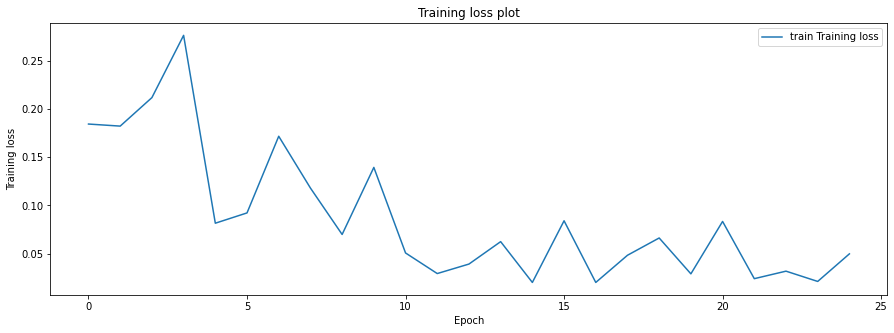

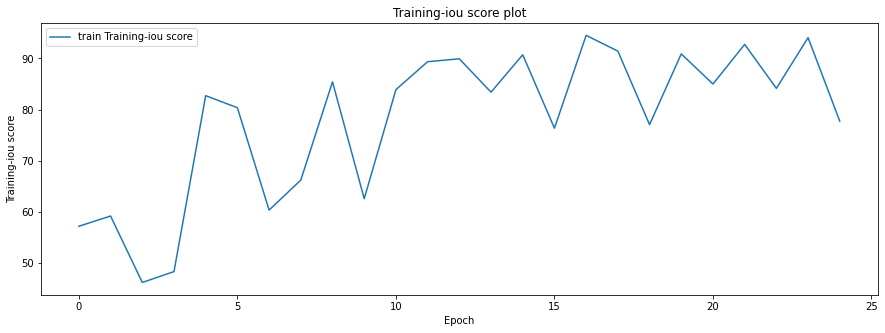

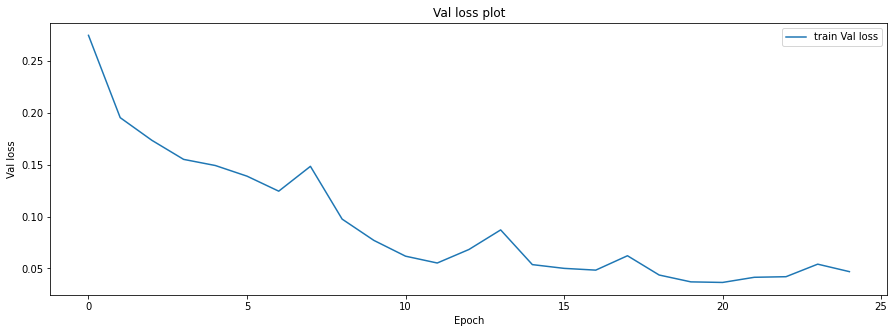

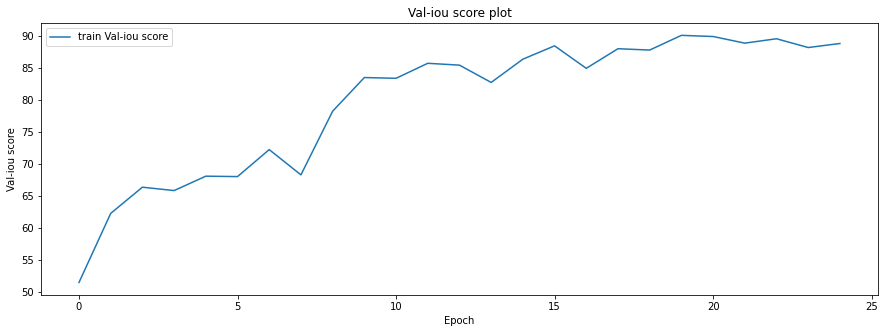

In [35]:
#25epochs-test_train split
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")
plot(epoch_val_losses, "Val loss")
plot(epoch_val_iou, "Val-iou score")

In [36]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/best-model'))

<All keys matched successfully>

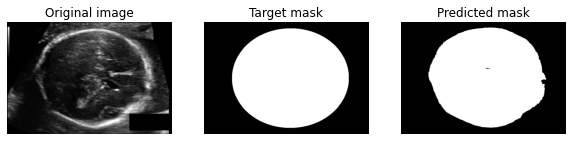

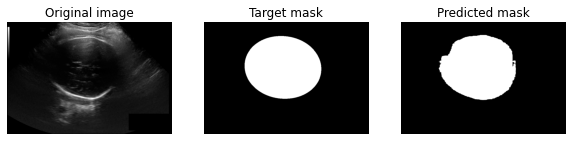

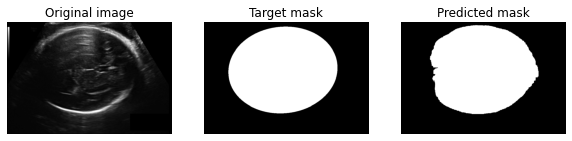

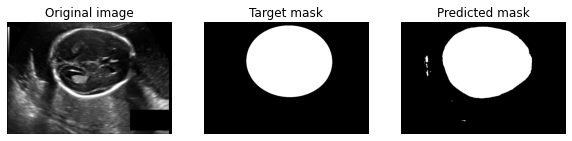

Finished Evaluation


In [37]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(valLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [38]:
del model
with torch.no_grad():
  torch.cuda.empty_cache()

#DUNET

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 96
LEARNING_RATE = 1e-3

In [ ]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

# scattering = Scattering2D(J=2, shape=(544, 800), backend='torch_skcuda')
scattering = Scattering2D(J=2, shape=(544, 800))
scattering.cuda()

def scatter_img(img):
  return scattering(img)

In [ ]:
# x = torch.randn(1,544,800)
# b = scattering(x.cuda()).squeeze(dim=0)
# print(b.shape)

In [ ]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        scattering = scatter_img(image).squeeze(dim=0).detach()
        sample = {'image': image, 'mask': mask, 'scatter': scattering}
        return sample

In [ ]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [ ]:
traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
i=0
trainname=[]
start=0
# with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        if (start>20):
          break
        start+=1
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [ ]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [ ]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
class Dunet(nn.Module):
    def __init__(self):
        super(Dunet, self).__init__()
       
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),   
            nn.MaxPool2d(2, stride=2), nn.ReLU(True)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),   nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),  
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),   
            nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),   
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.scatter = nn.Sequential(
            nn.Conv2d(81, 256, 3, padding=1),   
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),   nn.ReLU(True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),   nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),    nn.ReLU(True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.conv_merge_1= nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_2= nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_3= nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_4= nn.Sequential(
            nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_5=nn.Sequential(
            nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2), 
            nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), 
            nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), 
            nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), 
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.Conv2d(32, 1, 3, padding=1),   nn.Sigmoid(),
        )

    def forward(self, x, y):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x4 = self.encoder_4(x3)
        x5 = self.encoder_5(x4)
        b = self.scatter(y)
        c = torch.cat([x5,b],dim=1)
        # print("Model", x5.shape, b.shape, c.shape)
        d = self.conv_merge_1(c)
        y1 = self.decoder_1(d)
        f = torch.cat([x4,y1],dim=1)
        g = self.conv_merge_2(f)
        y2 = self.decoder_2(g)
        h = torch.cat([x3,y2],dim=1)
        i = self.conv_merge_3(h)
        y3 = self.decoder_3(i)
        j = torch.cat([x2,y3],dim=1)
        k = self.conv_merge_4(j)
        y4 = self.decoder_4(k)
        l = torch.cat([x1,y4],dim=1)
        m = self.conv_merge_5(l)
        n = self.decoder_5(m)
        return n

model = Dunet().to(device=device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/hc18/saved_model29'))
# summary(model, [(1, 544, 800),(81,136,200)])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/old-best-model/-iou:45.268966403891376'))

In [ ]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [ ]:
model = model.to(device)
model.train()

iou_score = []
dice_loss = []
best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score.append(np.mean(iou))
    dice_loss.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score':iou_score, 'dice_loss': dice_loss}, fid)

    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
    
    if iou_score[-1]>best_iou_score:
        best_iou_score = iou_score[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/epoch_iousAndArrays.pkl', 'rb') as fid:
     iou_score = pickle.load(fid)['iou_score']
     dice_loss = pickle.load(fid)['dice_loss']

In [ ]:
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best-model'))

In [ ]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        print("image:",images.shape)
        print("masks:",masks.shape)
        outputs = model(images)
        print("output:",outputs.shape)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 1
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 2
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        # output=np.array(output)
        # output[output>75]=255
        # output[output<=75]=0
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)
        # print(np.array(output))
        # print(output.max())
        # print(output.mean())
        break

print('Finished Evaluation')

#UNET - smp (without validation)

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [ ]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

In [ ]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [ ]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [ ]:
traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
i=0
trainname=[]
# start=0
# with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        # if (start>20):
        #   break
        # start+=1
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [ ]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [ ]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)

criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [ ]:
model.train()

# iou_score = []
# dice_loss = []
best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score.append(np.mean(iou))
    dice_loss.append(np.mean(loss_arr))
    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score':iou_score, 'dice_loss': dice_loss}, fid)

    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
    

    if iou_score[-1]>best_iou_score:
        best_iou_score = iou_score[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

In [ ]:
print(best_iou_score)

In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score = data['iou_score']
    dice_loss = data['dice_loss']
    print(np.min(dice_loss))

In [ ]:
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model'))

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))


        # loss = criterion(out, masks)
        # print("Mini - Batch ",k,"Loss", loss.item())
        # print("output:",outputs.shape)

        # Detach
        # print(images[0].shape)
        
        # Plot and see
        

        # i = 0
        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()

        # i = 1
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # # output = transforms.ToPILImage()(outputs[i])
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')

        # i = 2
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # # output = transforms.ToPILImage()(outputs[i])
        # # output=np.array(output)
        # # output[output>75]=255
        # # output[output<=75]=0
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)co
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')
        # # print(np.array(output))
        # # print(output.max())
        # # print(output.mean())
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

print('Finished Evaluation')
print('iou:',np.mean(iou))

In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp(dont\ touch)/best_iou.pkl', 'wb') as fid:
    pickle.dump(np.mean(iou))

#UNET - smp

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [ ]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

In [ ]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [ ]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [ ]:
# traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
# i=0
# trainname=[]
# # start=0
# # with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
# with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
#     r=csv.reader(s)
#     for com in r:
#         # if (start>20):
#         #   break
#         # start+=1
#         if i==0:
#             i+=1
#         else:
#             i+=1
#             trainname.append(com[0])
# files=trainname

In [ ]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [ ]:
# train, val = train_test_split(files, test_size = 0.2)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'wb') as fid:
#     pickle.dump(train, fid)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'wb') as fid:
#     pickle.dump(val, fid)

with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'rb') as fid:
    train = pickle.load(fid)
with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'rb') as fid:
    val = pickle.load(fid)
    
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,train,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

Val_Dataset = HeadDataset(image_folder,mask_folder,val,transform)
valLoader = DataLoader(Val_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)

criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [ ]:
iou_score_train = []
dice_loss_train = []
iou_score_val= []
dice_loss_val = []

best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    ##training
    model.train()
    for i, data in enumerate(trainLoader, 0):

        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Training: Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score_train.append(np.mean(iou))
    dice_loss_train.append(np.mean(loss_arr))

    ##evaluation
    model.eval()
    with torch.no_grad():
        iou = []
        loss_arr = []
        for k, data in enumerate(valLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images = data['image'].to(device)
            masks = data['mask'].to(device)
            # scatters = data['scatter']

            outputs = model(images)
            loss = criterion(outputs, masks)
            print("Validation: Mini - Batch ",k,"Loss", loss.item())

            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())
   
    iou_score_val.append(np.mean(iou))
    dice_loss_val.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score_train':iou_score_train, 'dice_loss_train': dice_loss_train, 'iou_score_val':iou_score_val, 'dice_loss_val':dice_loss_val}, fid)

    if epoch % 1 == 0:
        print("Epoch [{}]: Train - iou: {}, loss: {}; Val - iou: {}, loss: {}".format(epoch, iou_score_train[-1], dice_loss_train[-1], iou_score_val[-1], dice_loss_val[-1]))
        running_loss = 0.0
    

    if iou_score_val[-1]>best_iou_score:
        best_iou_score = iou_score_val[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

Training: Mini - Batch  0 Loss 0.838517427444458
Training: Mini - Batch  1 Loss 0.6015425324440002
Training: Mini - Batch  2 Loss 0.40521037578582764
Training: Mini - Batch  3 Loss 0.517696738243103
Training: Mini - Batch  4 Loss 0.36449575424194336
Training: Mini - Batch  5 Loss 0.24397122859954834
Training: Mini - Batch  6 Loss 0.1407356858253479
Training: Mini - Batch  7 Loss 0.1654297113418579
Training: Mini - Batch  8 Loss 0.10828542709350586
Training: Mini - Batch  9 Loss 0.07765281200408936
Training: Mini - Batch  10 Loss 0.08207392692565918
Training: Mini - Batch  11 Loss 0.0896419882774353
Training: Mini - Batch  12 Loss 0.06302517652511597
Training: Mini - Batch  13 Loss 0.054262757301330566
Training: Mini - Batch  14 Loss 0.10627198219299316
Training: Mini - Batch  15 Loss 0.05520278215408325
Training: Mini - Batch  16 Loss 0.0549660325050354
Training: Mini - Batch  17 Loss 0.05101370811462402
Training: Mini - Batch  18 Loss 0.08917546272277832
Training: Mini - Batch  19 Los

In [ ]:
print(best_iou_score)

93.48348995870343


In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train = data['iou_score_train']
    dice_loss_train = data['dice_loss_train']
    iou_score_val = data['iou_score_val']
    dice_loss_val = data['dice_loss_val']
    print(dice_loss_val[np.argmax(iou_score_val)])
    print(np.max(iou_score_val))

0.023744082450866698
93.48348995870343


In [ ]:
epoch_train_losses = dice_loss_train
epoch_train_iou = iou_score_train
epoch_val_losses = dice_loss_val
epoch_val_iou = iou_score_val
print(epoch_train_losses)
print(epoch_train_iou)
print(epoch_val_losses)
print(epoch_val_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

[0.022456824779510498, 0.03704434633255005, 0.04493820667266846, 0.025098741054534912, 0.029884755611419678, 0.031054437160491943, 0.02373826503753662, 0.02315288782119751, 0.031936466693878174, 0.022062063217163086, 0.022950947284698486, 0.022562265396118164, 0.02913421392440796, 0.02448195219039917, 0.024641215801239014, 0.018052399158477783, 0.02275097370147705, 0.02420884370803833, 0.017613351345062256, 0.04531615972518921, 0.018585562705993652, 0.02012568712234497, 0.01828467845916748, 0.01911604404449463, 0.051296353340148926]
[96.05715926538369, 89.86693524630475, 84.15396221403275, 92.38908238883735, 89.88403046001837, 93.01108325305728, 94.05346581602367, 92.83597256218977, 89.22760724431811, 94.56560501291825, 93.99332847373596, 93.17842696311163, 90.6899989772406, 92.85425694752675, 91.23204136559673, 94.44674275508599, 93.85706048652817, 91.84796296930608, 94.90256983203781, 89.54103195723204, 93.76891009258861, 93.6164563706265, 94.40528229754773, 95.14599054787463, 91.280

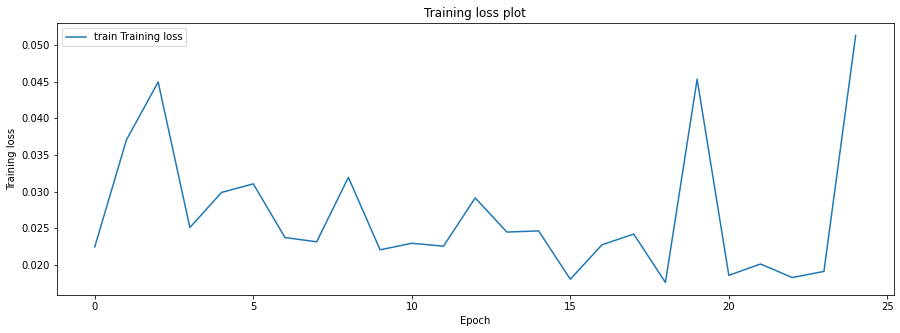

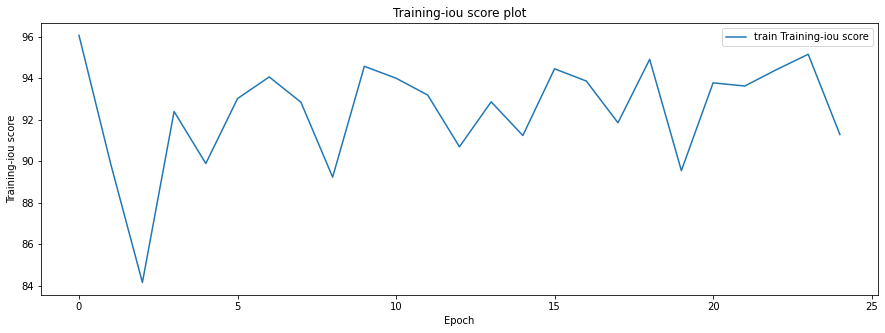

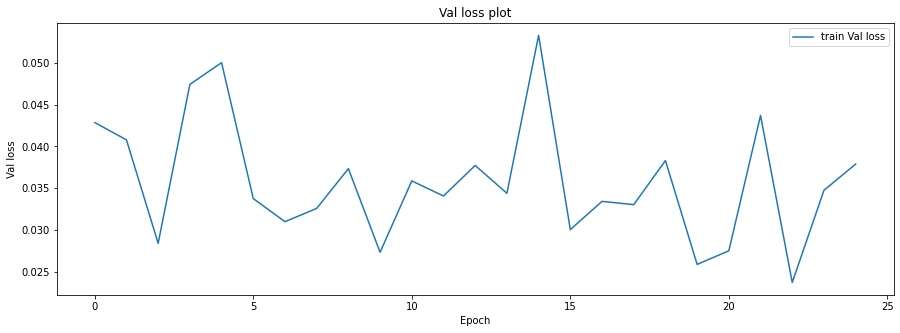

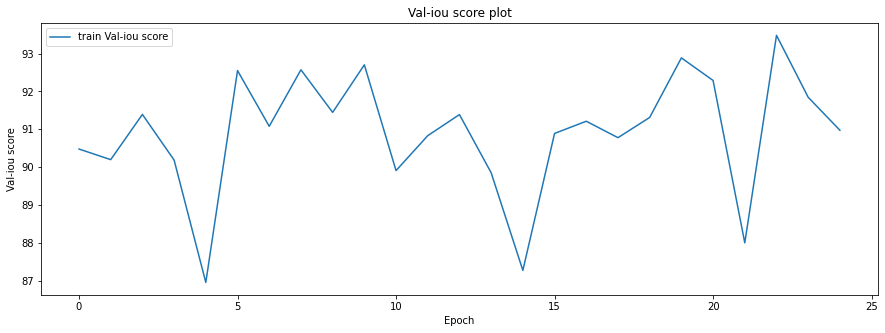

In [ ]:
#25epochs-test_train split
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")
plot(epoch_val_losses, "Val loss")
plot(epoch_val_iou, "Val-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model'))

<All keys matched successfully>

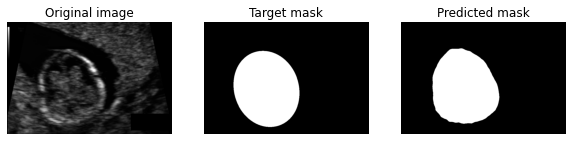

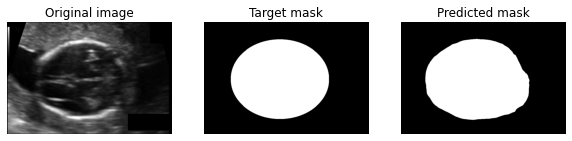

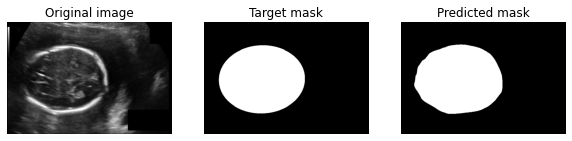

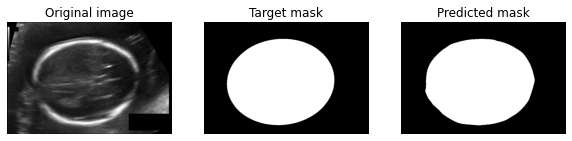

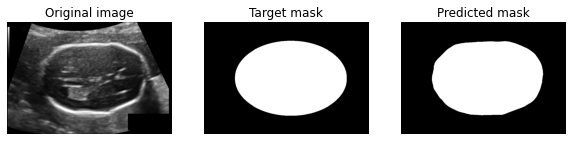

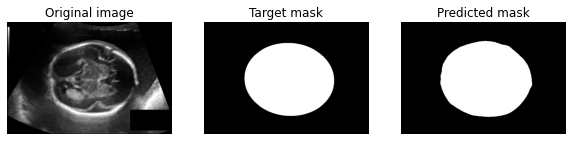

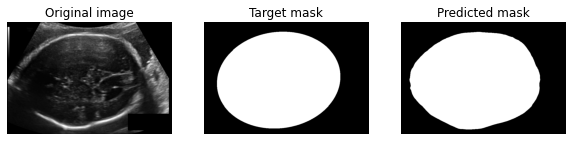

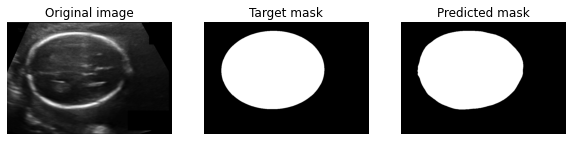

Finished Evaluation


In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(valLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))


        # loss = criterion(out, masks)
        # print("Mini - Batch ",k,"Loss", loss.item())
        # print("output:",outputs.shape)

        # Detach
        # print(images[0].shape)
        
        # Plot and see
        

        # i = 0
        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()

        # i = 1
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # # output = transforms.ToPILImage()(outputs[i])
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')

        # i = 2
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # # output = transforms.ToPILImage()(outputs[i])
        # # output=np.array(output)
        # # output[output>75]=255
        # # output[output<=75]=0
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)co
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')
        # # print(np.array(output))
        # # print(output.max())
        # # print(output.mean())
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))